Contexte :

Import des bibliothèques 

In [478]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go

Téléchargement du jeu de données

In [479]:
data = pd.read_csv('https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv')

In [480]:
display(data.head())
#display(data.columns.to_list())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Enlever tout ce qui est residentiel. Outliers ~ Quartile. ComplianceStatus variables à considérer. Type de classifier  : Regression linéaire, Lasso, Ridge. 

Point d'attention : Corrélation entre variables. dataleak ~ fuite de données. corrélation entre feature et target. Normaliser les variables. 

Impact de energystar sur la qualité de la regression. 

:Partie Analyse exploratoire : Durée de traitement à évaluer. 

### Choix des variables 

Après exploration de la liste des variables, nous en ont retenu deux : **TotalGHGEmissions** et **SiteEnergyUse(kBtu)** qui nous constituent les variables que nous allons essayer de prédire à partir d'autres varaibles qu'on aura choisi.

Ainsi notre étude sera initiée avec comme variables expliquuées TotalGHGEmissions, SiteEnergyUse(kBtu) et comme variables explicatives 

In [481]:
variables  =  ["OSEBuildingID","BuildingType", "PrimaryPropertyType","Address", "City","State","ZipCode","Latitude","Longitude", "DataYear","YearBuilt",
               "NumberofBuildings" , "NumberofFloors", "PropertyGFATotal", "SiteEUI(kBtu/sf)","PropertyGFAParking",
               "SiteEUIWN(kBtu/sf)",  "SiteEnergyUseWN(kBtu)", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ENERGYSTARScore", "ComplianceStatus", 
               "Outlier", "TotalGHGEmissions","GHGEmissionsIntensity" , "SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","PropertyGFABuilding(s)","PropertyGFAParking"
               ]

In [482]:
data1=data[variables]

Notre étude ne portant que sur les bâtiments non déstinés à l'habitation, nous allons converver ceux-là et exclure les autres types de bâtiments du jeu de données.

In [483]:
data1['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Les bâtiments qui nous interessent sont ceux appartenant aux catégories "NonResidential" , "NonResidential COS", "SPS-District K-12" et "Nonresidential WA".Au total 1668 bâtiments composent ces 5 catégories.

In [484]:
data1[(data1['BuildingType']=='NonResidential') & (data1['PrimaryPropertyType']=='Low-Rise Multifamily')]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking
644,19445,NonResidential,Low-Rise Multifamily,2108 N Pacific St.,Seattle,WA,98103.0,47.64859,-122.33311,2016,...,Compliant,NaN,25.60,0.28,1.997182e+06,0.0,252982.0,1744199.0,56986,36093
2450,25674,NonResidential,Low-Rise Multifamily,916 E PIKE ST,Seattle,WA,98122.0,47.61427,-122.31977,2016,...,Non-Compliant,Low outlier,5.22,0.16,1.082004e+05,0.0,96830.0,11370.0,32100,0


In [485]:
data1["LargestPropertyUseType"].value_counts()

Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Supermarket/Grocery Store                                 41
Medical Office                                            41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
Residence Hall/Dormitory

In [486]:
display(data1[(data1["BuildingType"]=="NonResidential")  & (data1["LargestPropertyUseType"] == "Multifamily Housing")])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking
164,264,NonResidential,Mixed Use Property,516 1st Ave W,Seattle,WA,98119.0,47.623900,-122.357560,2016,...,Compliant,NaN,92.91,0.84,1.055791e+07,0.0,418354.0,10139555.0,110785,0
644,19445,NonResidential,Low-Rise Multifamily,2108 N Pacific St.,Seattle,WA,98103.0,47.648590,-122.333110,2016,...,Compliant,NaN,25.60,0.28,1.997182e+06,0.0,252982.0,1744199.0,56986,36093
1159,21122,NonResidential,Mixed Use Property,3424 Fremont Ave. N.,Seattle,WA,98103.0,47.650200,-122.349590,2016,...,Compliant,NaN,110.17,2.63,4.193371e+06,0.0,1754275.0,2439095.0,32601,9226
1839,23562,NonResidential,Mixed Use Property,80 Yesler Way,Seattle,WA,98104.0,47.601950,-122.335160,2016,...,Compliant,NaN,5.37,0.12,7.697713e+05,0.0,0.0,769771.0,43878,0
2314,25222,NonResidential,Mixed Use Property,737 Olive Way,Seattle,WA,98101.0,47.613760,-122.334450,2016,...,Compliant,NaN,449.59,0.42,2.641677e+07,0.0,5752789.0,20663978.0,962428,112124
2394,25522,NonResidential,Mixed Use Property,5401 26th Ave NE,Seattle,WA,98105.0,47.668270,-122.299780,2016,...,Compliant,NaN,34.62,1.07,1.391714e+06,0.0,540057.0,851657.0,25297,6985
2450,25674,NonResidential,Low-Rise Multifamily,916 E PIKE ST,Seattle,WA,98122.0,47.614270,-122.319770,2016,...,Non-Compliant,Low outlier,5.22,0.16,1.082004e+05,0.0,96830.0,11370.0,32100,0
2748,26834,NonResidential,Mixed Use Property,525 MAYNARD AVE S,Seattle,WA,98104.0,47.597690,-122.325370,2016,...,Compliant,NaN,20.78,1.01,7.474569e+05,0.0,337398.0,410059.0,20620,0
3003,27838,NonResidential,Mixed Use Property,1600 E. Madison St.,Seattle,WA,98122.0,47.615540,-122.310980,2016,...,Compliant,NaN,83.65,1.58,3.392129e+06,0.0,1300504.0,2091625.0,38409,14625
3041,27969,NonResidential,Mixed Use Property,1700 E Madison St,Seattle,WA,98122.0,47.616080,-122.309670,2016,...,Compliant,NaN,7.12,0.07,1.021755e+06,0.0,0.0,1021754.0,97229,0


Non compliant à éliminer 

Il y a 11 résidence non destinés à l'habitation mais qui sont en partiellement utilisés pour heberger des familles.

In [487]:
display(data1[ ((data1["BuildingType"]=="Campus") | (data1["BuildingType"]=="Nonresidential WA"))  & (data1["LargestPropertyUseType"] == "Multifamily Housing")])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking
1300,21481,Campus,Low-Rise Multifamily,1525 FIrst Avenue,Seattle,WA,98101.0,47.60918,-122.34079,2016,...,Compliant,NaN,26.34,0.58,3778355.0,0.0,0.0,3778355.0,45500,0


1 bâtiment de type campus utilisé comme lieu d'habitat pour famille. 

On garde les bâtiments non destinés à l'habitation

In [488]:
data1 = data1[ (data1["BuildingType"]=="NonResidential") |  (data1["BuildingType"]=="Nonresidential COS") | (data1["BuildingType"]=="Campus") |(data1["BuildingType"]=="Nonresidential WA") ]

#### Suppression des doublons

In [489]:
data1[data1.duplicated(subset=['OSEBuildingID'], keep=False) == True].sort_values(by=['OSEBuildingID'])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking


In [490]:
data1 = data1.drop_duplicates(subset=["OSEBuildingID"], keep='first')

In [491]:
data1.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3371    False
3372    False
3373    False
3374    False
3375    False
Length: 1570, dtype: bool

Pas de doublons dans notre jeu de données

#### Conformité du type de chaque variable et recherche de valeur manquante

In [492]:
data1.dtypes

OSEBuildingID                     int64
BuildingType                     object
PrimaryPropertyType              object
Address                          object
City                             object
State                            object
ZipCode                         float64
Latitude                        float64
Longitude                       float64
DataYear                          int64
YearBuilt                         int64
NumberofBuildings               float64
NumberofFloors                    int64
PropertyGFATotal                  int64
SiteEUI(kBtu/sf)                float64
PropertyGFAParking                int64
SiteEUIWN(kBtu/sf)              float64
SiteEnergyUseWN(kBtu)           float64
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ENERGYSTARScore                 float64
ComplianceStatus                 object
Outlier                          object
TotalGHGEmissions               float64
GHGEmissionsIntensity           float64


In [493]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  2
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   3
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 3
SiteEnergyUseWN(kBtu)              3
LargestPropertyUseType             6
SecondLargestPropertyUseType     717
ENERGYSTARScore                  559
ComplianceStatus                   0
Outlier                         1554
TotalGHGEmissions                  2
GHGEmissionsIntensity              2
SiteEnergyUse(kBtu)                2
SteamUse(kBtu)                     2
N

Parmi les variables qui présentent des valeurs manquantes, seules les variables **ENERGYSTARScore** et **SiteEnergyUse(kBtu)** est une variable d'intêret majeur pour notre étude. Il va valoir choisir une méthode adaptée pour imputer les valeurs manquantes de cette variable. Mais avant cela, vérifions s'il n'y a pas de valeurs abberantes dans chaque colonne de notre jeu de données. 

#### Recherche de valeurs abberantes

In [494]:
data1[ (data1["OSEBuildingID"] <0) | (data1["OSEBuildingID"]==0) |  (data1["OSEBuildingID"]=="")]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking


In [495]:
data1[ (data1["GHGEmissionsIntensity"] <=0) | (data1["ENERGYSTARScore"]<=0) |  (data1["Electricity(kBtu)"]<=0)] [['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking'
 ]]


,OSEBuildingID,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUI(kBtu/sf),LargestPropertyUseType,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking,PropertyGFAParking
304,435,NonResidential,Other,1.0,6,1400000,NaN,Convention Center,NaN,Non-Compliant,NaN,0.00,0.00,0.000000e+00,0.0,0.0,0.0,1400000,0,0
426,23854,NonResidential,Restaurant,1.0,1,43728,263.200012,Restaurant,NaN,Compliant,NaN,611.19,13.98,1.150804e+07,0.0,11508035.0,0.0,43728,0,0
513,700,NonResidential,Supermarket / Grocery Store,1.0,1,57176,208.800003,Supermarket/Grocery Store,31.0,Compliant,NaN,0.00,0.00,1.252517e+07,0.0,0.0,0.0,57176,0,0
746,19776,NonResidential,Other,1.0,1,29924,0.000000,Other - Education,NaN,Missing Data,NaN,0.00,0.00,0.000000e+00,0.0,0.0,0.0,29924,0,0
1229,21315,NonResidential,Small- and Mid-Sized Office,1.0,3,57720,1.000000,Office,NaN,Non-Compliant,Low outlier,0.17,0.00,2.410550e+04,0.0,0.0,24105.0,57720,0,0
2189,24717,NonResidential,Other,1.0,3,27690,0.700000,Other,NaN,Non-Compliant,Low outlier,0.12,0.00,1.680890e+04,0.0,0.0,16809.0,27690,0,0
3206,49784,NonResidential,Small- and Mid-Sized Office,1.0,6,52000,7.100000,Office,100.0,Compliant,NaN,-0.80,-0.02,3.427261e+05,0.0,0.0,-115417.0,52000,0,0


Suppression des bâtiments dont les valeurs en consommation d'energy semblent incohérentes.

In [496]:
data1 = data1.drop(labels=3206, axis=0)
data1 = data1.drop(labels=513, axis=0)
data1 = data1.drop(labels=746, axis=0)
data1 = data1.drop(labels=304, axis=0)

- On remarque que *SiteEnergyUse(kBtu) = SteamUse(kBtu) + Electricity(kBh) + NaturalGas(kBtu)* . Vérifions si cette égalité est respecté pour toutes les observations du jeu de données.

In [497]:
data1["is_true_EnergyUse_Sum"] = np.where ( abs( (data1["SiteEnergyUse(kBtu)"])-(data1["SteamUse(kBtu)"]+data1["NaturalGas(kBtu)"]+data1["Electricity(kBtu)"]) ) <100, True, False )

In [498]:
data1["Ecart_energyUse_sumEnergy"]  = (data1["SiteEnergyUse(kBtu)"])-(data1["SteamUse(kBtu)"]+data1["NaturalGas(kBtu)"]+data1["Electricity(kBtu)"])

In [499]:
data1[data1["is_true_EnergyUse_Sum"]==False] [["OSEBuildingID",	"BuildingType","SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","Ecart_energyUse_sumEnergy"]]

,OSEBuildingID,BuildingType,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),Ecart_energyUse_sumEnergy
69,103,Nonresidential COS,2.365898e+07,6093150.0,688680.0,14419146.0,2.458002e+06
70,104,Nonresidential COS,8.141156e+06,4120130.0,0.0,3754115.0,2.669105e+05
71,106,Nonresidential COS,2.095503e+07,9763690.0,0.0,7252325.0,3.939011e+06
73,110,Nonresidential COS,2.726369e+06,1202380.0,0.0,1293349.0,2.306400e+05
75,112,Nonresidential COS,2.072325e+07,5137220.0,0.0,13512686.0,2.073342e+06
206,328,NonResidential,4.084775e+07,0.0,538251.0,40839637.0,-5.301360e+05
329,466,NonResidential,6.176238e+07,5650343.5,9571816.0,46528618.0,1.160250e+04
371,523,NonResidential,1.132551e+07,0.0,336610.0,10986553.0,2.350000e+03
403,561,NonResidential,9.058916e+06,0.0,0.0,7877393.0,1.181523e+06
448,608,NonResidential,1.119592e+07,0.0,343050.0,1608768.0,9.244099e+06


On trouve 28  bâtiments dont la consommation d'énergie totale n'est pas égale à la somme des energies consommées. Pour ces bâtiments l'égalité SiteEnergyUse(kBtu) = SteamUse(kBtu) + Electricity(kBh) + NaturalGas(kBtu)  n'est pas respectée. 

In [500]:
data1.columns.to_list()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'is_true_EnergyUse_Sum',
 'Ecart_energyUse_sumEnergy']

In [501]:
data1[['OSEBuildingID','BuildingType','PrimaryPropertyType','PropertyGFATotal','SiteEnergyUse(kBtu)','Ecart_energyUse_sumEnergy','is_true_EnergyUse_Sum']]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEnergyUse(kBtu),Ecart_energyUse_sumEnergy,is_true_EnergyUse_Sum
0,1,NonResidential,Hotel,88434,7.226362e+06,0.5000,True
1,2,NonResidential,Hotel,103566,8.387933e+06,0.0000,True
2,3,NonResidential,Hotel,956110,7.258702e+07,6.0000,True
3,5,NonResidential,Hotel,61320,6.794584e+06,0.7500,True
4,8,NonResidential,Hotel,175580,1.417261e+07,1.0000,True
...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,12294,8.497457e+05,-0.1969,True
3372,50223,Nonresidential COS,Other,16000,9.502762e+05,0.1550,True
3373,50224,Nonresidential COS,Other,13157,5.765898e+06,0.1790,True
3374,50225,Nonresidential COS,Mixed Use Property,14101,7.194712e+05,0.0105,True


Nous avons aussi que  SiteEUI(kBtu/sf) = SiteEnergyUse(kBtu) / (PropertyGFATotal-PropertyGFAParking) . Vérifions si cette égalité est respectée pour toutes nos obervations

In [502]:
data1["SiteEUI_calculated"] = data1["SiteEnergyUse(kBtu)"] / (data1["PropertyGFATotal"])
data1["is_true_EUIcalculated_eq_EUI"] = np.where ( abs(data1["SiteEUI_calculated"] - data1["SiteEUI(kBtu/sf)"]) <= 2.5, True, False)
data1["is_true_EUIcalculated_eq_EUI"].value_counts() /len(data1)

True     0.593231
False    0.406769
Name: is_true_EUIcalculated_eq_EUI, dtype: float64

On voit que cette égalité est respectée que pour 929 observations (soit 59,3%) de notre jeu de données.

In [503]:
check= ['OSEBuildingID','BuildingType','PrimaryPropertyType','PropertyGFATotal','SiteEUI(kBtu/sf)' ,"SiteEUI_calculated" ,'SiteEnergyUse(kBtu)','is_true_EUIcalculated_eq_EUI','is_true_EnergyUse_Sum']
data1[(data1["is_true_EUIcalculated_eq_EUI"]==False) & (data1["is_true_EnergyUse_Sum"]==False )] [check]



,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEUI(kBtu/sf),SiteEUI_calculated,SiteEnergyUse(kBtu),is_true_EUIcalculated_eq_EUI,is_true_EnergyUse_Sum
69,103,Nonresidential COS,Other,389000,64.300003,60.819995,2.365898e+07,False,False
70,104,Nonresidential COS,Other,91213,125.199997,89.254333,8.141156e+06,False,False
71,106,Nonresidential COS,Other,396085,75.199997,52.905376,2.095503e+07,False,False
75,112,Nonresidential COS,Other,262048,70.000000,79.081878,2.072325e+07,False,False
206,328,NonResidential,Large Office,791396,60.299999,51.614807,4.084775e+07,False,False
371,523,NonResidential,Large Office,280957,68.699997,40.310485,1.132551e+07,False,False
403,561,NonResidential,Large Office,336700,41.599998,26.905007,9.058916e+06,False,False
448,608,NonResidential,Large Office,154159,58.000000,72.625776,1.119592e+07,False,False
578,773,NonResidential,Small- and Mid-Sized Office,63150,NaN,NaN,NaN,False,False
601,803,NonResidential,Small- and Mid-Sized Office,85126,465.500000,445.829805,3.795171e+07,False,False


In [504]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  2
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   2
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 3
SiteEnergyUseWN(kBtu)              3
LargestPropertyUseType             6
SecondLargestPropertyUseType     715
ENERGYSTARScore                  557
ComplianceStatus                   0
Outlier                         1550
TotalGHGEmissions                  2
GHGEmissionsIntensity              2
SiteEnergyUse(kBtu)                2
SteamUse(kBtu)                     2
N

Suppression des observations qui ont très peu de valeurs pour les variables ci-dessous

In [505]:
col =  ["NumberofBuildings" , "NumberofFloors", "PropertyGFATotal", "SiteEUI(kBtu/sf)","PropertyGFAParking","SiteEUIWN(kBtu/sf)",  "SiteEnergyUseWN(kBtu)"
        , "TotalGHGEmissions","GHGEmissionsIntensity" , "SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)", 
         ]
data1[check] [data1[col].isnull().any(axis=1)]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEUI(kBtu/sf),SiteEUI_calculated,SiteEnergyUse(kBtu),is_true_EUIcalculated_eq_EUI,is_true_EnergyUse_Sum
563,757,NonResidential,Large Office,131143,39.5,39.478054,5177270.5,True,False
578,773,NonResidential,Small- and Mid-Sized Office,63150,NaN,NaN,NaN,False,False
2670,26532,NonResidential,Mixed Use Property,20760,NaN,NaN,NaN,False,False


In [506]:
data1 = data1.drop(labels=576, axis=0)
data1 = data1.drop(labels=2670, axis=0)

In [507]:
data1= data1[(data1["is_true_EnergyUse_Sum"]==True)]

In [508]:
data1.shape

(1537, 35)

In [509]:
from wordcloud import WordCloud

def trace_word(df,column,nb_top=25):
  fig = plt.figure(1, figsize=(15,11))
  ax1 = fig.add_subplot(1,1,1)

  words= df[column].value_counts().to_dict()  

  word_cloud = WordCloud(width=1000,height=520, normalize_plurals=False,background_color="black")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des top {}  {}\n".format(nb_top, column), fontsize=21)
  plt.show()

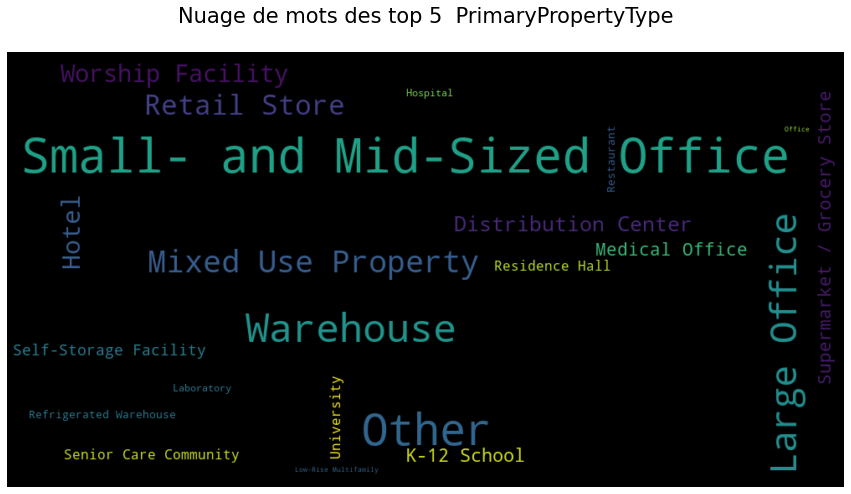

In [510]:
trace_word(df=data1,column="PrimaryPropertyType",nb_top=5)

5% des bâtiments qui ont la plus grande surface.

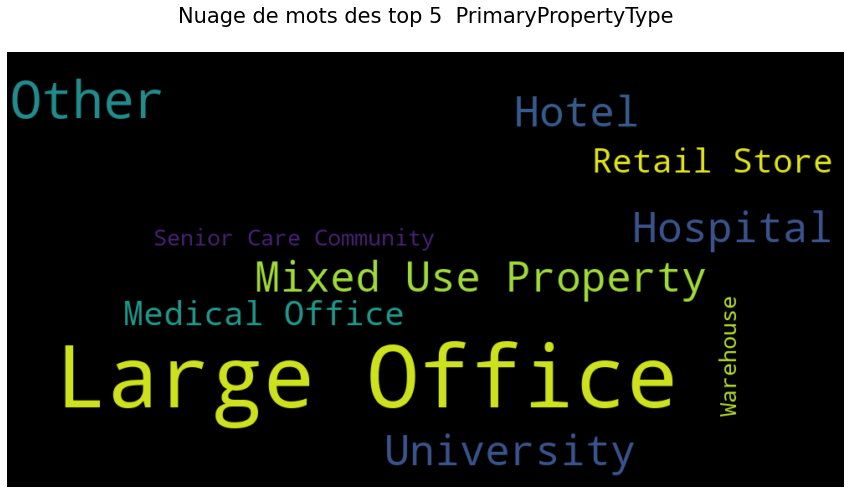

In [511]:
trace_word(df=data1[ data1["PropertyGFATotal"]> data1["PropertyGFATotal"].quantile(.95)],column="PrimaryPropertyType",nb_top=5)

#### Imputation des valeurs manquantes 

In [512]:
col1 = [ "OSEBuildingID",	"BuildingType",	"PrimaryPropertyType"	,"Address", "PropertyGFATotal", "NumberofBuildings","SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","SteamUse(kBtu)"]

In [513]:
data1[ data1["SiteEnergyUse(kBtu)"].isnull()] [col1]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,PropertyGFATotal,NumberofBuildings,SiteEnergyUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu)


In [514]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   0
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 0
SiteEnergyUseWN(kBtu)              0
LargestPropertyUseType             4
SecondLargestPropertyUseType     697
ENERGYSTARScore                  540
ComplianceStatus                   0
Outlier                         1522
TotalGHGEmissions                  0
GHGEmissionsIntensity              0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
N

- La seule variable à imputer est *ENERSTARScore*. Obeservons d'abord sa distribution



In [515]:
data_bf_imp = data1.copy()

In [516]:
fig = px.histogram(data1, x="ENERGYSTARScore")
fig.show()

Avant d'imputer je crée une colonne contenant les étiquettes pour chaque bâtiment dont l'"ENERGYSTARScore"  est manquant.

In [517]:
data1['is_energyStarImputed'] = np.where (data1["ENERGYSTARScore"].isnull(), True, False)

In [518]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

# Entrainenement du modèle d'imputation sur un échantillon
knn_features = ["NumberofBuildings","SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","SteamUse(kBtu)", "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)","TotalGHGEmissions","GHGEmissionsIntensity",  
                "SiteEnergyUseWN(kBtu)","ENERGYSTARScore","PropertyGFABuilding(s)"]
sample_datas = data1[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)


KNNImputer()

In [519]:
data1[knn_features]

,NumberofBuildings,SiteEnergyUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUseWN(kBtu),ENERGYSTARScore,PropertyGFABuilding(s)
0,1.0,7.226362e+06,1.276453e+06,3.946027e+06,2003882.00,81.699997,84.300003,249.98,2.83,7.456910e+06,60.0,88434
1,1.0,8.387933e+06,5.145082e+06,3.242851e+06,0.00,94.800003,97.900002,295.86,2.86,8.664479e+06,61.0,88502
2,1.0,7.258702e+07,1.493800e+06,4.952666e+07,21566554.00,96.000000,97.699997,2089.28,2.19,7.393711e+07,43.0,759392
3,1.0,6.794584e+06,1.811213e+06,2.768924e+06,2214446.25,110.800003,113.300003,286.43,4.67,6.946800e+06,56.0,61320
4,1.0,1.417261e+07,8.803998e+06,5.368607e+06,0.00,114.800003,118.699997,505.01,2.88,1.465650e+07,75.0,113580
...,...,...,...,...,...,...,...,...,...,...,...,...
3371,1.0,8.497457e+05,3.254750e+05,5.242709e+05,0.00,69.099998,76.699997,20.94,1.70,9.430032e+05,46.0,12294
3372,1.0,9.502762e+05,5.537300e+05,3.965461e+05,0.00,59.400002,65.900002,32.17,2.01,1.053706e+06,NaN,16000
3373,1.0,5.765898e+06,3.973739e+06,1.792159e+06,0.00,438.200012,460.100006,223.54,16.99,6.053764e+06,NaN,13157
3374,1.0,7.194712e+05,3.706010e+05,3.488702e+05,0.00,51.000000,55.500000,22.11,1.57,7.828413e+05,NaN,14101


In [520]:
# Application du modèle sur l'ensemble des données
datas_imputed = imputer.transform(data1[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)
data1["ENERGYSTARScore"] = df_datas_imputed["ENERGYSTARScore"].values

- Comparaison de la distribution de la variable Energystar score avant et après imputation.

In [521]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2)

trace0 = go.Histogram(x=data_bf_imp["ENERGYSTARScore"], name ="ENERGYSTARScore")
trace1 = go.Histogram(x=data1["ENERGYSTARScore"], name = "Knn_imputed")

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)


fig.show()

- Boxplot des deux distributions

In [522]:
fig = go.Figure()
fig.add_trace(go.Box(y=data1["ENERGYSTARScore"]))
fig.add_trace(go.Box(y=data_bf_imp["ENERGYSTARScore"], name="Knn_imputed"))
fig.show()

In [523]:
list_address =data1[data1["ZipCode"].isnull() ] ["Address"].to_list()

- Imputation du Zipcode 

In [524]:
data1["ZipCode"].isnull().sum()

16

In [525]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   0
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 0
SiteEnergyUseWN(kBtu)              0
LargestPropertyUseType             4
SecondLargestPropertyUseType     697
ENERGYSTARScore                    0
ComplianceStatus                   0
Outlier                         1522
TotalGHGEmissions                  0
GHGEmissionsIntensity              0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
N

In [526]:
data1["SecondLargestPropertyUseType"].fillna ("Other", inplace =True)
data1["Outlier"].fillna("inconnue", inplace =True)
data1["LargestPropertyUseType"].fillna ("Other", inplace =True)

In [527]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   0
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 0
SiteEnergyUseWN(kBtu)              0
LargestPropertyUseType             4
SecondLargestPropertyUseType     697
ENERGYSTARScore                    0
ComplianceStatus                   0
Outlier                         1522
TotalGHGEmissions                  0
GHGEmissionsIntensity              0
SiteEnergyUse(kBtu)                0
SteamUse(kBtu)                     0
N

In [528]:
data1 =data1[data1["BuildingType"]!='Nonresidential WA']

In [529]:
data1["BuildingType"].value_counts()

NonResidential        1437
Nonresidential COS      76
Campus                  23
Name: BuildingType, dtype: int64

### Analyse exploratoire 

- Boxplot des variables quantitatives 

In [530]:
#Calcul de l'âge du bâtiment en 2016
data1["age_batiment"] = 2016-data1["YearBuilt"]

#Choix des variables numériques
var_numeriques=list(data1.select_dtypes(include=["float64","int64"]).columns) 
var_numeriques= var_numeriques [-(len(var_numeriques)-5):]
var_numeriques

fig = go.Figure()
for variable in var_numeriques :
  fig.add_trace(go.Box(y=data1[variable], name=variable))
fig.show()

Le graphique montre que certaines variables contiennent potentiellement des valeurs qui sont soit abberantes soit atypiques.

On voit que les variables *SiteEnergyUse(kBtu)*, *SiteEnergyUseWN(kBtu)*, *SteamUse(kBtu)*, *Electricity(kBh)*, et *NaturalGas(kBtu)* ont des valeurs qui semblent être soit abberantes ou soit atypiques. Affinons l'analyse des ces valeurs pour réellement savoir si elles sont réllement abberantes. 

Etant donné que  *SiteEnergyUse(kBtu)* = *SteamUse(kBtu)* + *Electricity(kBh)* + *NaturalGas(kBtu)*, il ne serait pas surprenant  de voir que les batiments détenant des valeurs abberantes pour une variable donnée soient identiques à ceux détenant des abberantes/atypiques pour les autres.

Nous allons extraire les bâtiments ayant des valeurs abberantes/atypiques pour chacune des variables mentionnées plus haut. Nous aurons ainsi 4 groupes de bâtiments que nous allons comparer pour voir si ils sont indentiques.

L'objectif étant de vérifier que le groupe de bâtiments ayant des valeurs abberantes/atypiques pour la variable *SiteEnergyUse(kBtu)* est similaire aux groupes ayant des valeurs abberantes/atypiques pour *SteamUse(kBtu)* , *Electricity(kBh)* et *NaturalGas(kBtu)*.



In [531]:
x=data1[ data1["SiteEnergyUse(kBtu)"] > data1["SiteEnergyUse(kBtu)"].quantile(0.98)]

#Bâtiment à valeur abberantes pour la variable SiteEnergyUse(kBtu)
x1=data1[ data1["SiteEnergyUse(kBtu)"] > data1["SiteEnergyUse(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable NaturalGas(kBtu)
x2=data1[ data1["NaturalGas(kBtu)"] > data1["NaturalGas(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable SteamUse(kBtu)
x3=data1[ data1["SteamUse(kBtu)"] > data1["SteamUse(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable  Electricity(kBtu)
x4=data1[ data1["Electricity(kBtu)"] > data1["Electricity(kBtu)"].quantile(0.98)]["OSEBuildingID"]

In [532]:
print (len(set(x1).intersection(set(x3)))/ len(x3) )

0.1935483870967742


19% des valeurs abberantes/atypiques des variables "SiteEnergyUse(kBtu) et NaturalGas(kBtu)  

In [533]:
print (len(set(x2).intersection(set(x1))) /len(x2)  )

0.4838709677419355


48,3% des valeurs abberantes/atypiques des variables "NaturalGas(kBtu) sont atypiques/abberantes pour SiteEneergyUse(kBtu)  

In [534]:
print (len(set(x1).intersection(set(x1))) /len(x4)  )

1.0


In [535]:
print (len(set(x3).intersection(set(x4)))/ len(x3) )

0.16129032258064516


- Energy star score 

Distribution ENERGYStarScore

In [536]:
fig = px.histogram(data1.sort_values(by="OSEBuildingID") , x="ENERGYSTARScore").update_xaxes(categoryorder='total descending')
fig.show()

Boxplot EnergyStarScore

In [537]:
fig = px.box(data1, y="ENERGYSTARScore")
fig.show()

Quelques bâtiments ayant un energystarScore inférieur à 8. Observons ça de plus près.

In [538]:
col3  =  ["OSEBuildingID","BuildingType", "PrimaryPropertyType","YearBuilt", "NumberofBuildings" , "NumberofFloors", "PropertyGFATotal"
              ,"SiteEnergyUseWN(kBtu)", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ENERGYSTARScore","TotalGHGEmissions","SiteEnergyUse(kBtu)"]

data1[data1["ENERGYSTARScore"]<=8][col3] 

,OSEBuildingID,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse(kBtu)
35,43,Campus,Mixed Use Property,1992,1.0,3,494835,4.716139e+08,Office,Laboratory,8.0,16870.98,4.483853e+08
60,85,NonResidential,Senior Care Community,1970,1.0,2,93397,1.695975e+07,Senior Care Community,NaN,1.0,609.10,1.640256e+07
193,313,NonResidential,Medical Office,1927,1.0,5,190000,2.873150e+07,Medical Office,Office,1.0,661.04,2.873150e+07
194,314,NonResidential,Hotel,1961,1.0,4,122309,2.612202e+07,Hotel,NaN,8.0,1060.13,2.545369e+07
253,379,NonResidential,Large Office,1984,1.0,8,253103,2.994925e+07,Office,Parking,3.0,208.79,2.994925e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,27142,NonResidential,K-12 School,1912,1.0,4,27800,1.275996e+06,K-12 School,NaN,8.0,38.36,1.181429e+06
2930,27567,NonResidential,Small- and Mid-Sized Office,1995,1.0,3,20410,2.827857e+06,Office,NaN,8.0,77.84,2.720238e+06
3060,28025,Nonresidential COS,Warehouse,1967,1.0,2,22058,2.235498e+06,Non-Refrigerated Warehouse,Office,1.0,66.43,1.987335e+06
3065,28033,NonResidential,Distribution Center,1971,1.0,1,28320,4.403066e+06,Distribution Center,Parking,1.0,67.96,4.236396e+06


64 bâtiments qui ont une ENRGYSTARScore très basse.

In [539]:
low_EnergyStar = data1[data1["ENERGYSTARScore"]<=8][col3] 
low_EnergyStar["OSEBuildingID"] = low_EnergyStar["OSEBuildingID"].apply(str)

In [540]:
surface_median =data1["PropertyGFATotal"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="PropertyGFATotal"), x='PropertyGFATotal', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=surface_median, y0=0, x1=surface_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

In [541]:
energy_median = data1["SiteEnergyUse(kBtu)"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="SiteEnergyUse(kBtu)"), x='SiteEnergyUse(kBtu)', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=energy_median, y0=0, x1=energy_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

In [542]:
nbFloor_median = data1["NumberofFloors"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="NumberofFloors"), x='NumberofFloors', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=nbFloor_median, y0=0, x1=nbFloor_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On remarque que les bâtiments qui ont une energystarSCore Basse ont en général une consommation d'enégergie plus supérieure à la consommation d'énérgie médiane, 35% d'entre eux ont une surface plus grande que la surface médiane et 65,5% ont un NumberofFloor supérieur ou égal à 2.

-  Emission de carbone

In [543]:
data1.columns.to_list()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'is_true_EnergyUse_Sum',
 'Ecart_energyUse_sumEnergy',
 'SiteEUI_calculated',
 'is_true_EUIcalculated_eq_EUI',
 'is_energyStarImputed',
 'age_batiment']

In [544]:
fig = px.box(data1, y="TotalGHGEmissions")
fig.show()

Observons le boxplot sans les valeurs atypiques

In [545]:
fig = px.box(data1[data1["TotalGHGEmissions"]<data1["TotalGHGEmissions"].quantile(0.80)], y="TotalGHGEmissions")
fig.show()

Quels sont les bâtiments qui ont ces valeurs atypiques 

In [546]:
x_sup=data1[data1["TotalGHGEmissions"]>data1["TotalGHGEmissions"].quantile(0.80)]
x_inf=data1[data1["TotalGHGEmissions"]<data1["TotalGHGEmissions"].quantile(0.80)]

Ces bâtiments sont-ils les bâtiments qui ont la plus grande surface ? la plus consomation d'énergie ? Quel est l'usage dont on fait de ces batiments ? 

In [547]:
data1.columns.to_list()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'is_true_EnergyUse_Sum',
 'Ecart_energyUse_sumEnergy',
 'SiteEUI_calculated',
 'is_true_EUIcalculated_eq_EUI',
 'is_energyStarImputed',
 'age_batiment']

In [548]:
x_sup_hist=x_sup.groupby("PrimaryPropertyType").agg({'OSEBuildingID': 'count', 'PropertyGFATotal': 'mean', 'SiteEnergyUse(kBtu)':'mean'}).reset_index()[["PrimaryPropertyType","OSEBuildingID","PropertyGFATotal","SiteEnergyUse(kBtu)"]]
fig = px.bar(x_sup_hist.sort_values(by="OSEBuildingID"), x="OSEBuildingID", y="PrimaryPropertyType").update_xaxes(categoryorder='total descending')
fig.show()

Les valeurs en emssions de carbone atypiques concernenent les supermarchés, Hotels, Large Office

In [549]:
x_sup_hist1=x_sup.groupby("LargestPropertyUseType").agg({'OSEBuildingID': 'count', 'PropertyGFATotal': 'mean'}).reset_index()[["LargestPropertyUseType","OSEBuildingID","PropertyGFATotal"]]
fig = px.histogram(x_sup_hist1.sort_values(by="OSEBuildingID"), x='OSEBuildingID', y='LargestPropertyUseType', text_auto=True)
fig.show()

In [550]:
x_sup1 = x_sup.copy()
x_sup1["OSEBuildingID"] = x_sup1["OSEBuildingID"].apply(str)

In [551]:
surface_median =data1["PropertyGFATotal"].median()
fig = px.histogram(x_sup1.sort_values(by="PropertyGFATotal"), x='PropertyGFATotal', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=surface_median, y0=0, x1=surface_median,y1=305,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On voit que ces bâtiments ont pour la plupart une surface  supérieure à la surface médiane.

In [552]:
energy_median = data1["SiteEnergyUse(kBtu)"].median()
fig = px.histogram(x_sup1.sort_values(by="SiteEnergyUse(kBtu)"), x='SiteEnergyUse(kBtu)', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=energy_median, y0=0, x1=energy_median,y1=305,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On voit que ces bâtiments ont pour la plupart une consommation d'énérgie  supérieure à la consommation d'énérgie médiane.

Donc on peut conclure que ces valeurs sont bien des valeurs atypiques. 

- Correlation entre le PropertyPrimaryType et la Surface ?

In [553]:
data1["count"] =1

Répartion des bâtiments selon l'année de construction

In [554]:
fig = px.histogram(data1, x='YearBuilt', text_auto=True)
fig.show()

Y-a-t'il une influence entre le LargestPropertyUse et l'emissionen carbonne. 

In [555]:
fig = px.box(data1.sort_values (by="TotalGHGEmissions"), x="LargestPropertyUseType", y="TotalGHGEmissions")
fig.show()

Anova  entre  TotalGHGEmissions~ C(LargestPropertyUseType)

In [556]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
model = ols('TotalGHGEmissions~ C(LargestPropertyUseType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(LargestPropertyUseType),2.637174e+08,54.0,13.074691,1.425129e-90
Residual,5.516887e+08,1477.0,NaN,NaN


La p-value est inférieure à 0.05. Donc on rejette l'hypothèse nulle. On peut donc affirmer que le LargestPrportyUse a bien un impact sur l'emission de carbone.

Nous allons tout de même vérifier que les hypothèses du modèles anaova sont resepctées. Mêmes si les hyptothèses du modèles ne sont pas toutes vérifiées, notre modèle restera valable vu que ANOVA n'exige qu'un respect approximatif des conditions.

In [557]:
from statsmodels.stats.stattools import durbin_watson
#perform Durbin-Watson test
durbin_watson(model.resid)

#H0 : Les résidus sont indépendantes

1.9486261292554754

In [558]:
from scipy import stats
#Evaluation de l'hypothèse de normalité des résidus
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)
#H0:  Le données suivent une loi normale

0.2397993803024292 0.0


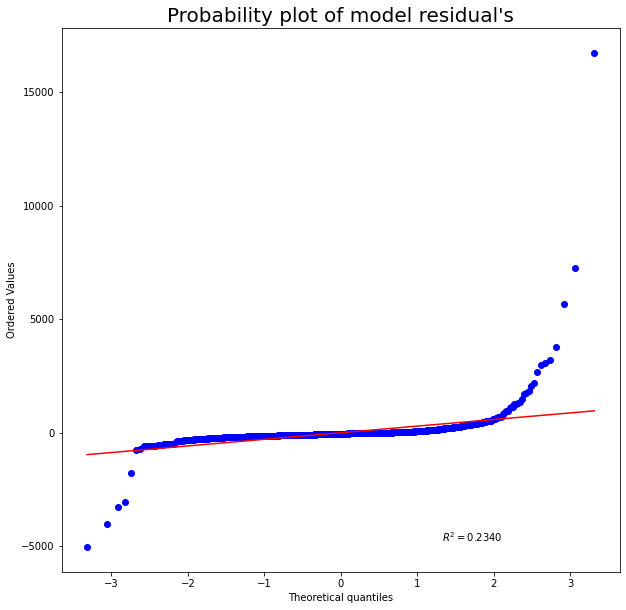

In [559]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [560]:
#Création des pivot tabble pour le test de Bartlett
food_data_pivot=data1[['OSEBuildingID','LargestPropertyUseType','TotalGHGEmissions']].pivot(index=['OSEBuildingID'],columns="LargestPropertyUseType", values="TotalGHGEmissions")
food_data_pivot

LargestPropertyUseType,NaN,Adult Education,Automobile Dealership,Bank Branch,College/University,Courthouse,Data Center,Distribution Center,Financial Office,Fire Station,...,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [561]:
#food_data_pivot=food_data_pivot.fillna(0)
#w, pvalue = stats.bartlett(food_data_pivot['a'], food_data_pivot['b'],food_data_pivot['c'], food_data_pivot['d'],food_data_pivot['e'])
#print(w, pvalue)
#H0 : La variances sont identiques (homogénité)

In [562]:
Eta_squared=2.634213e+08 /(2.634213e+08+5.520820e+08)

Corrélation entre EnergyStarScore et LargestPropertyUse

In [563]:
fig = px.box(data1.sort_values (by="ENERGYSTARScore"), x="LargestPropertyUseType", y="ENERGYSTARScore")
fig.show()

In [564]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
model = ols('ENERGYSTARScore~ C(LargestPropertyUseType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(LargestPropertyUseType),73242.719402,54.0,2.358346,1.827022e-07
Residual,849461.555350,1477.0,NaN,NaN


Corrélation entre TotalGhGemission et PrimaryPropertyType

In [565]:
# Ordinary Least Squares (OLS) model
model = ols('TotalGHGEmissions~ C(PrimaryPropertyType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(PrimaryPropertyType),2.651960e+08,21.0,34.744699,2.434293e-113
Residual,5.502816e+08,1514.0,NaN,NaN


Corrélation entre  ENERGYSTARScore et PrimaryPropertyType

In [566]:
# Ordinary Least Squares (OLS) model
model = ols('ENERGYSTARScore~ C(PrimaryPropertyType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(PrimaryPropertyType),71524.151551,21.0,6.047599,2.265921e-16
Residual,852660.847173,1514.0,NaN,NaN


La p value confirme que nous pouvons rejeter l'indépendance de la variable SiteEnergyUseWN(kBtu) vis à vis des modalités de la variable PrimaryPropertyType.

On va créer de nouvelles variables afin d'améliorer notre feature engenireeng

In [567]:
#On calcule les ratios
data1['Ratio_buildingParSurface'] =round(data['PropertyGFABuilding(s)']/data['PropertyGFATotal'],2)

data1['Ratio_parkingParSurface'] = round(data['PropertyGFAParking']/data['PropertyGFATotal'],2)


data1['SurfaceParBatiment'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),2)

data1['SurfaceParetage'] = round(data['PropertyGFATotal'] / (data['NumberofFloors']+1),2)

In [568]:
data1[data1["NumberofFloors"]==0]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,Ecart_energyUse_sumEnergy,SiteEUI_calculated,is_true_EUIcalculated_eq_EUI,is_energyStarImputed,age_batiment,count,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParBatiment,SurfaceParetage
166,267,NonResidential,Hotel,721 Pine St,Seattle,WA,98101.0,47.61275,-122.33330,2016,...,8.00,69.622007,False,True,17,1,1.0,0.0,934292.00,934292.0
487,656,NonResidential,Medical Office,1221 Madison Street,Seattle,WA,98104.0,47.60979,-122.32298,2016,...,2.00,90.983450,False,False,12,1,1.0,0.0,225982.00,225982.0
488,657,NonResidential,Mixed Use Property,2200 Westlake Ave.,Seattle,WA,98121.0,47.61783,-122.33729,2016,...,5.00,76.302839,True,False,10,1,1.0,0.0,inf,516407.0
564,758,NonResidential,Other,600 Pine Street,Seattle,WA,98101.0,47.61289,-122.33531,2016,...,6.00,49.062867,False,True,17,1,1.0,0.0,947987.00,947987.0
1754,23311,NonResidential,Medical Office,1124 Columbia Street,Seattle,WA,98104.0,47.60862,-122.32372,2016,...,2.00,92.186730,False,False,71,1,1.0,0.0,274568.00,274568.0
1993,24086,Campus,Other,1333 AIRPORT WAY S,Seattle,WA,98134.0,47.59042,-122.32498,2016,...,3.00,91.017002,True,True,25,1,1.0,0.0,23097.10,230971.0
3130,40028,NonResidential,Warehouse,7561 63rd Ave NE,Seattle,WA,98115.0,47.68454,-122.26235,2016,...,2.00,39.521488,False,False,76,1,1.0,0.0,384772.00,384772.0
3131,40031,NonResidential,Medical Office,6222 NE 74th St,Seattle,WA,98115.0,47.68240,-122.26223,2016,...,0.00,72.411100,False,False,56,1,1.0,0.0,30287.00,30287.0
3132,40034,NonResidential,Small- and Mid-Sized Office,6200 NE 74th ST,Seattle,WA,98115.0,47.68254,-122.26299,2016,...,-0.75,179.983095,False,False,56,1,1.0,0.0,21931.00,21931.0
3168,49705,Nonresidential COS,Other,7400 Sand Point Way NE,Seattle,WA,98115.0,47.68212,-122.26330,2016,...,1.00,36.791307,False,True,87,1,1.0,0.0,62753.75,502030.0


In [569]:
var_numeriques

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'ENERGYSTARScore',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'Ecart_energyUse_sumEnergy',
 'SiteEUI_calculated',
 'age_batiment']

In [570]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'SiteEUI_calculated',
 'PropertyGFAParking',
 'ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'age_batiment',
 'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
 'SurfaceParetage'
 ]]

In [571]:
matrix = data_model.corr()
fig = px.imshow(matrix, text_auto=True,aspect="auto")
fig.show()

Nous remarquons que certaines variables ont une forte corrélation linéaire. Et cela peut susciter des colinéarité entre certaines variables, ce qui n'est pas très bon pour notre modèle.

Nous savons que SiteEnergyUse (Kbtu) = SteamUse(kBtu) + NaturalGas(kBtu) + Electricity (kBtu). Il y a donc une colinéarité entre ces 4 variables. Nous allons donc supprimer les 3 variables situées à droite de l'égalité dans nos modèles.

In [572]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'ENERGYSTARScore',
 'age_batiment',
  'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
 'SurfaceParetage'
 ]]

In [573]:
matrix = data_model.corr()
fig = px.imshow(matrix, text_auto=True,aspect="auto")
fig.show()

Nos deux variables à prédire sont formtement coréllées. 
On nolte aussi une corrélation modérée entre NumberofFlorrs et PropertyGFAtOTAL , entre SiteEnergyUse(kbtu) et PropertyGFATotal.   Il faut savoir que lorsqu’on fait une régression linéaire on pose certaines hypothèses notamment la Non-colinéarité des variables explicatives (une variable explicative ne doit pas pouvoir s’écrire comme combinaison linéaire des autres). Après une analyse minutieuse nous choisissons les variables 

Nous allons vérifier la multicolinéarité des variables à l'aide du VIF 

In [574]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = data_model

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)


                     feature        VIF
0        SiteEnergyUse(kBtu)  12.202942
1          TotalGHGEmissions   8.825257
2          NumberofBuildings   1.101980
3             NumberofFloors   2.560849
4           PropertyGFATotal   4.227748
5           SiteEUI(kBtu/sf)   1.495958
6            ENERGYSTARScore   1.142011
7               age_batiment   1.200398
8   Ratio_buildingParSurface  15.483258
9    Ratio_parkingParSurface   1.568514
10           SurfaceParetage   1.812331


Nos deux variables à variables à prédire ont un vif supérieure à 5.

In [575]:
data1.dtypes

OSEBuildingID                     int64
BuildingType                     object
PrimaryPropertyType              object
Address                          object
City                             object
State                            object
ZipCode                         float64
Latitude                        float64
Longitude                       float64
DataYear                          int64
YearBuilt                         int64
NumberofBuildings               float64
NumberofFloors                    int64
PropertyGFATotal                  int64
SiteEUI(kBtu/sf)                float64
PropertyGFAParking                int64
SiteEUIWN(kBtu/sf)              float64
SiteEnergyUseWN(kBtu)           float64
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ENERGYSTARScore                 float64
ComplianceStatus                 object
Outlier                          object
TotalGHGEmissions               float64
GHGEmissionsIntensity           float64


In [576]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'age_batiment',
 'LargestPropertyUseType',
 'PrimaryPropertyType',
 "BuildingType",
 'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
  'SurfaceParetage'
 ]].copy()

Nous allons utilisé oneHotenconder afin d'encoder les variables catégorielles. Nous allons cependant exclure les catégories les moins représentées afin de limiter le nombre de variables dans notre modèle. 

In [577]:
ppt=pd.DataFrame(data_model['PrimaryPropertyType'].value_counts())
ppt

,PrimaryPropertyType
Small- and Mid-Sized Office,287
Other,235
Warehouse,187
Large Office,166
Mixed Use Property,112
Retail Store,90
Hotel,76
Worship Facility,71
Distribution Center,53
K-12 School,42


In [578]:
# ['Fire Station', 'Lifestyle Center', 'Other - Utility', 'Adult Education', 'Movie Theater', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Other - Restaurant/Bar']l
lpt=pd.DataFrame(data_model ['LargestPropertyUseType'].value_counts() )
lpt
data_model ['LargestPropertyUseType'].value_counts().mean()

27.854545454545455

In [579]:
l1=ppt[ppt.values<ppt.values.mean()].index.to_list()
l2=lpt[lpt.values<lpt.values.mean()].index.to_list()
l2

['Self-Storage Facility',
 'Residence Hall/Dormitory',
 'Other - Entertainment/Public Assembly',
 'College/University',
 'Senior Care Community',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Multifamily Housing',
 'Hospital (General Medical & Surgical)',
 'Social/Meeting Hall',
 'Manufacturing/Industrial Plant',
 'Strip Mall',
 'Automobile Dealership',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Fitness Center/Health Club/Gym',
 'Other - Services',
 'Other - Lodging/Residential',
 'Museum',
 'Library',
 'Other - Mall',
 'Bank Branch',
 'Financial Office',
 'Other/Specialty Hospital',
 'Data Center',
 'Other - Education',
 'Performing Arts',
 'Prison/Incarceration',
 'Urgent Care/Clinic/Other Outpatient',
 'Lifestyle Center',
 'Other - Public Services',
 'Other - Restaurant/Bar',
 'Adult Education',
 'Other - Utility',
 'Pre-school/Daycare',
 'Courthouse',
 'Wholesale Club/Supercenter',
 'Residential Care Facility',
 'Police Station',
 'Food Service',
 'Movie The

On met les catégories dont la fréquence est inférence à la moyenne dans la catégorie "Other".

In [580]:
data_model['PrimaryPropertyType'] = np.where(data_model['PrimaryPropertyType'].isin(l1),"Other",data_model['PrimaryPropertyType'])
data_model['LargestPropertyUseType'] = np.where(data_model['LargestPropertyUseType'].isin(l2),"Other",data_model['LargestPropertyUseType'])

In [581]:
data_model

,SiteEnergyUse(kBtu),TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,age_batiment,LargestPropertyUseType,PrimaryPropertyType,BuildingType,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParetage
0,7.226362e+06,249.98,1.0,12,88434,60.0,89,Hotel,Hotel,NonResidential,1.00,0.00,6802.62
1,8.387933e+06,295.86,1.0,11,103566,61.0,20,Hotel,Hotel,NonResidential,0.85,0.15,8630.50
2,7.258702e+07,2089.28,1.0,41,956110,43.0,47,Hotel,Hotel,NonResidential,0.79,0.21,22764.52
3,6.794584e+06,286.43,1.0,10,61320,56.0,90,Hotel,Hotel,NonResidential,1.00,0.00,5574.55
4,1.417261e+07,505.01,1.0,18,175580,75.0,36,Hotel,Hotel,NonResidential,0.65,0.35,9241.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,8.497457e+05,20.94,1.0,1,12294,46.0,26,Office,Other,Nonresidential COS,1.00,0.00,6147.00
3372,9.502762e+05,32.17,1.0,1,16000,78.2,12,Other - Recreation,Other,Nonresidential COS,1.00,0.00,8000.00
3373,5.765898e+06,223.54,1.0,1,13157,62.4,42,Other - Recreation,Other,Nonresidential COS,1.00,0.00,6578.50
3374,7.194712e+05,22.11,1.0,1,14101,83.2,27,Other - Recreation,Mixed Use Property,Nonresidential COS,1.00,0.00,7050.50


In [582]:
from google.colab import drive
drive.mount('/content/drive')

filepath ='/content/drive/MyDrive/food_openfood.csv'

#food_data.to_csv(filepath,encoding= 'utf-8')  
data_model.to_csv(filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [583]:
data_model['PrimaryPropertyType'].value_counts()

Other                          547
Small- and Mid-Sized Office    287
Warehouse                      187
Large Office                   166
Mixed Use Property             112
Retail Store                    90
Hotel                           76
Worship Facility                71
Name: PrimaryPropertyType, dtype: int64

In [584]:
data_model ['LargestPropertyUseType'].value_counts()

Office                        485
Other                         365
Non-Refrigerated Warehouse    199
Retail Store                   98
Hotel                          76
Worship Facility               71
Distribution Center            54
K-12 School                    42
Medical Office                 41
Supermarket/Grocery Store      40
Other - Recreation             31
Parking                        30
Name: LargestPropertyUseType, dtype: int64

Encodage des variables catégorielles 

#Modélisation

Séparation du jeu de données 

In [585]:
numerical_features = data_model.select_dtypes(include=['int64','float64']).columns.to_list()
categorical_features = data_model.select_dtypes(exclude=['int64','float64']).columns.to_list()

In [586]:
categorical_features 

['LargestPropertyUseType', 'PrimaryPropertyType', 'BuildingType']

In [587]:
numerical_features 

['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'age_batiment',
 'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
 'SurfaceParetage']

In [588]:
X= data_model[['NumberofBuildings','NumberofFloors',"BuildingType",'PropertyGFATotal','ENERGYSTARScore','age_batiment','LargestPropertyUseType','PrimaryPropertyType', 'Ratio_buildingParSurface','Ratio_parkingParSurface', 'SurfaceParetage']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

### Passage au log pour notre varaible target TotalGHGEmissions



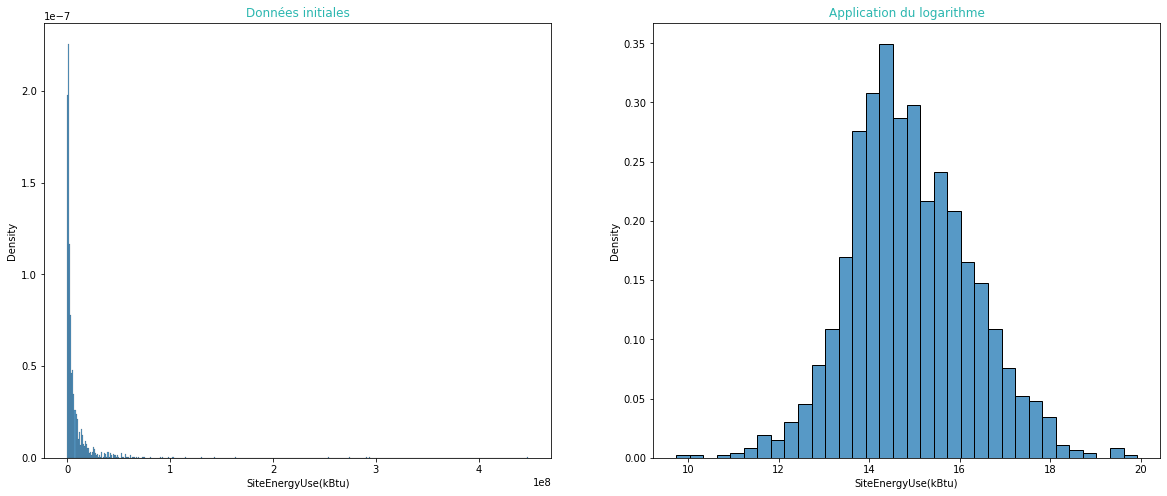

In [589]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

###Pipeline utilisé

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn import set_config
set_config(display='diagram')

#plot distribution de la target et voir le scaler à utiliser 

Modèle baseline : Régression linéaire

In [8]:
# Création de piepeline pour les features numériques et catégoriels   ----  'SiteEnergyUse(kBtu)','TotalGHGEmissions',
numerical_features  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment', 'Ratio_buildingParSurface','Ratio_parkingParSurface', 'SurfaceParetage']
categorical_features  = [ 'LargestPropertyUseType','PrimaryPropertyType',"BuildingType"]


numerical_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='mean')),
      ('scale',StandardScaler())
  ])
categorical_pipeline= Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())     #TargetEncoder()
  ])


  # Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline',numerical_pipeline,numerical_features),
      ('categorical_pipeline=',categorical_pipeline,categorical_features )
      ],
      remainder='passthrough',
      #n_jobs=-1,
      )


# Ajouter le modèle au pipeline final
model_baseline= Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", TransformedTargetRegressor(regressor=DummyRegressor(strategy="mean")  ,func=np.log, inverse_func=np.exp))]
)


#X = data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)
#Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=8)


model_baseline.fit (X_train,Y_train['TotalGHGEmissions'])


NameError: ignored

On utilise deux métriques pour l’évaluation L’erreur quadratique moyenne (l’erreur d’estimation) et le R-square (la qualité du modèle de régression)

In [592]:
y_train_predict = model_baseline.predict(X_train)
rmse = (mean_absolute_error(Y_train['TotalGHGEmissions'], y_train_predict))
r2 = r2_score(Y_train['TotalGHGEmissions'], y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------------------')
print('MAE : {}'.format(rmse))
#print(f'MSE : {mean_squared_error(Y_train['TotalGHGEmissions'], y_train_predict)}')
print('le score R2 est : {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = model_baseline.predict(X_test)
rmse = (mean_absolute_error(Y_test['TotalGHGEmissions'], y_test_predict))
r2 = r2_score(Y_test['TotalGHGEmissions'], y_test_predict)
 
print('La performance du modèle sur la base de test')
print('------------------------------------------------------')
print('MAE: {}'.format(rmse))
print('le score R2 est : {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------------------
MAE : 180.50106564218325
le score R2 est : -0.029411056449340833


La performance du modèle sur la base de test
------------------------------------------------------
MAE: 133.57364586929017
le score R2 est : -0.07193172503793921


Valeurs prédites vs valeurs réelles de notre modèle baseline

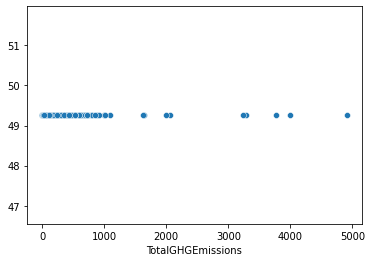

In [593]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
#y_test_predict = model_baseline.predict(X_test)
sns.scatterplot(x=Y_test['TotalGHGEmissions'], y=y_test_predict)

Pipeline, paramètre  et Gridsearch de tous les modèles à tester 

In [594]:
#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
nb_split = 5

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp) )]
)

myscore = ('r2','neg_mean_absolute_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 

score = ['accuracy','neg_mean_absolute_error']
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore,
        cv=nb_split,return_train_score=True)


tt = TransformedTargetRegressor(regressor=lr_grid_search ,
                                 func=np.log, inverse_func=np.exp)

#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)

elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-4, 0, num=5),
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]    
lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)

# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [2, 15, 25, 100],
                   'RFR__regressor__min_samples_split': [2, 5, 10],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5,10]}
                                                    ]  
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
        param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor
pipe_xgbr = Pipeline(
    steps=[("preprocessor", preprocessor), ("xgbr", xgb.XGBRegressor())]
)


"""xgbr_param_grid = [ {'xgbr__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
                          'xgbr__gamma': [0, 0.25, 0.5, 1.0],
                           'xgbr__max_depth': [6, 10, 15, 20],
                          'xgbr__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
                          'xgbr__n_estimators': [25, 50, 100, 500, 1000]}  ]""" 

xgbr_param_grid = [ {'xgbr__learning_rate' : [0.001],
                          'xgbr__gamma': [0],
                           'xgbr__max_depth': [6],
                          'xgbr__min_child_weight' : [0.5],
                          'xgbr__n_estimators': [25]}  ] 

xgbr_grid_search = GridSearchCV(estimator=pipe_xgbr,
        param_grid=xgbr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)                                                  
                                                


Entrainement des modèles et choix des meilleurs modèles

In [595]:
import warnings
warnings.filterwarnings('ignore')

global target
global lr_grid_search_model , elastic_grid_search_model, lsvr_grid_search_model, rfr_grid_search_model 

target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

#xgbr_grid_search_model = xgbr_grid_search.fit(X_train,Y_train[target[0]])


#pd.DataFrame(xgbr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)


In [ ]:
target_x =target[0]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train[target_x])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train[target_x])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train[target_x])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train[target_x])

## <ins> Choix du modèle pour la variable target 'TotalGHGEmissions' </ins>

In [ ]:
a=pd.DataFrame(lr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
R=pd.concat([a, b,c,d])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R

,params,mean_fit_time,mean_test_neg_mean_absolute_error,mean_test_r2,std_train_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,Modèles
0,{'LR__regressor__fit_intercept': True},0.030754,-61085.330932,-4.821413e+07,10.666115,1,LinearRegression
145,"{'ELN__regressor__alpha': 1.0, 'ELN__regressor...",0.031100,-173.603493,-1.287709e-02,12.107337,1,ElasticNet
49,"{'LSVR__regressor__C': 0.001, 'LSVR__regressor...",0.017786,-196.164786,-1.411350e-01,11.901153,1,SVR
132,"{'RFR__regressor__bootstrap': False, 'RFR__reg...",0.176936,-129.563046,3.884158e-01,1.478661,1,RandomForest


Avec la graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur score **MAE** (=-133) et un meilleur $R^2$ (=0.4) . On rentiendra ce modèle pour la modélisation de la 
variable **TotalGHGEmissions** est donc le modèle RandomForestRegressor.

Temps d'entrainement des modèles

In [ ]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entrainement',x=R['Modèles'], y=R['mean_fit_time'])])
fig.update_layout(barmode='group')

fig.show()

Observons les scores obtenus sur les différents splits de la Cross-validation :

### Code

In [ ]:
import plotly.express as px
def trace_mae() :
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error",	"split4_train_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error","split4_train_neg_mean_absolute_error"]]
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"]]

  df1_transposed = t1.T
  df1_transposed 
  df2_transposed = t2.T
  final=pd.concat ([df1_transposed,df2_transposed ])
  final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
  final.rename(columns={0: "MAE"}, inplace=True)
  final=final.reset_index()
  final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
  final

  fig = px.line( final, x='Split_cross validation',y='MAE', color='color', symbol="color")
  fig.show()

def trace_r2() :
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2",	"split4_train_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2","split4_train_r2"]]
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"]]

    df1_transposed = t1.T
    df1_transposed 
    df2_transposed = t2.T
    final=pd.concat ([df1_transposed,df2_transposed ])
    final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
    final.rename(columns={0: "R2"}, inplace=True)
    final=final.reset_index()
    final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
    final

    fig = px.line( final, x='Split_cross validation',y='R2', color='color', symbol="color")
    fig.show()



### Performance de notre modèle selectionné dans le train et le test set de  chaque split de la crossvalidation.

In [ ]:
trace_mae()
trace_r2()

On voit bien ici que la performance du modèle sur les données se rapproche de celle sur les données de test. On peut ne pas envisager un overffiting de notre modèle séléctionné.

### Score de notre modèle  sur le test set 

In [ ]:
y_test_predict = rfr_grid_search_model.predict(X_test)

In [ ]:
from sklearn.metrics import median_absolute_error, r2_score
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

In [ ]:
print(compute_score(Y_test[target[0]], y_test_predict ) ) 

{'R2': '0.274', 'MedAE': '26.329'}


Sur le test set Le MAE du modèle s'est amélioré tandis que son $R^2$ est presque divisé par 2.

Valeurs prédites vs valeurs réelles

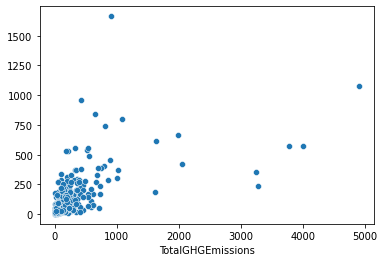

In [ ]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
sns.scatterplot(x=Y_test[target[0]], y=y_test_predict)

Ici, le modèle est n'est pas très bien ajusté aux données. 

## <ins> Choix du modèle pour la variable target SiteEnergyUse(kBtu) </ins>

In [ ]:
#Entrainement du modèle
target_x =target[1]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train[target_x])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train[target_x])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train[target_x])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train[target_x])

#Classement des modèles par score MAE et R2
a=pd.DataFrame(lr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
R=pd.concat([a, b,c,d])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R


,params,mean_fit_time,mean_test_neg_mean_absolute_error,mean_test_r2,std_train_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,Modèles
0,{'LR__regressor__fit_intercept': True},0.025789,-1.049419e+09,-4.515021e+06,494599.741779,1,LinearRegression
141,"{'ELN__regressor__alpha': 1.0, 'ELN__regressor...",0.040399,-6.830785e+06,4.759723e-02,338642.798529,1,ElasticNet
3,"{'LSVR__regressor__C': 0.0001, 'LSVR__regresso...",0.018144,-8.743095e+06,-2.042416e-01,365642.621919,1,SVR
145,"{'RFR__regressor__bootstrap': False, 'RFR__reg...",0.179158,-4.299244e+06,5.144518e-01,167921.259749,1,RandomForest


Avec la graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur score **MAE** $(=-4430551)$ et un meilleur $R^2$ (=0.49) . On rentiendra ce modèle pour la modélisation de la 
variable **SiteEneryUse(kbtu)** est donc le modèle RandomForestRegressor.

Temps d'entraînement de notre modèle choisi

In [ ]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entrainement',x=R['Modèles'], y=R['mean_fit_time'])])
fig.update_layout(barmode='group')
fig.show()

Observons les scores obtenus sur les différents splits de la Cross-validation :

In [ ]:
trace_mae()
trace_r2()

Avec la graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur score MAE. On rentiendra ce modèle pour la modélisation de la 
variable TotalGHGEmissions est donc le modèle RandomForestRegressor.

Score de notre modèle

In [ ]:
y_test_predict = rfr_grid_search_model.predict(X_test)
print(compute_score(Y_test[target[0]], y_test_predict ) )   

{'R2': '-509561947.959', 'MedAE': '2507254.311'}


On voit ici que la performance de notre modèle s'est déteriroré. Le modèle predit mal de nouvelles données.

Valeurs prédites vs valeurs réelles

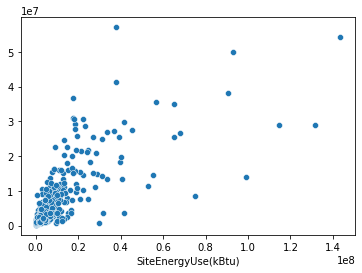

In [ ]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
y_test_predict = rfr_grid_search_model.predict(X_test)
sns.scatterplot(x=Y_test[target[1]], y=y_test_predict)


Le modèle n'arrive pas à généraliser sur le jeu de test. 

# <ins>Importance de EnergysStarScore</ins>

Nous allons voir si EnergyStar a un impact sur les modèles 

On enlève la variable ENERGYSTARScore

###Run du code

In [ ]:
X1= data_model[['NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','PrimaryPropertyType']]
Y1 = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

# Création de piepeline pour les features numériques et catégoriels   ----  'SiteEnergyUse(kBtu)','TotalGHGEmissions',
numerical_features1  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment']
categorical_features1  = ['PrimaryPropertyType']

global X1_train, X1_test, Y1_train, Y1_test 
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=8)

numerical_pipeline1 = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='mean')),
      ('scale',StandardScaler())
  ])
categorical_pipeline1= Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])


  # Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline1',numerical_pipeline1,numerical_features1),
      ('categorical_pipeline1=',categorical_pipeline1,categorical_features1 )
      ],
      remainder='passthrough',
      #n_jobs=-1,
      )

#X = data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)
#Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]








#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
nb_split = 5

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp) )]
)



lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 


lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='mean_test_score',
        #scoring='accuracy',
        cv=nb_split,return_train_score=True)


tt = TransformedTargetRegressor(regressor=lr_grid_search ,
                                 func=np.log, inverse_func=np.exp)

#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)

elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-4, 0, num=5),
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        #scoring='accuracy',
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]    
lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        #scoring='accuracy',
        cv=nb_split, return_train_score=True)

# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [5, 15, 25, 50],
                   'RFR__regressor__min_samples_split': [2, 5, 10],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5,10]}
                                                    ]  
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
        param_grid=rfr_param_grid,
        #scoring='accuracy',
        cv=nb_split, return_train_score=True)                                                  
                                                 


import warnings
warnings.filterwarnings('ignore')



target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

global R1, y_test_predict1,lr_grid_search_model1 ,elastic_grid_search_model1,lsvr_grid_search_model1 , rfr_grid_search_model1


target_x = target[0]
lr_grid_search_model1 = lr_grid_search.fit(X1_train,Y1_train[target_x])
elastic_grid_search_model1 = elastic_grid_search.fit(X1_train,Y1_train[target_x])
lsvr_grid_search_model1 = lsvr_grid_search.fit(X1_train,Y1_train[target_x])
rfr_grid_search_model1 = rfr_grid_search.fit(X1_train,Y1_train[target_x])


a=pd.DataFrame(lr_grid_search_model1.cv_results_)[['params',	'mean_fit_time', 'mean_test_score','std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
b=pd.DataFrame(elastic_grid_search_model1.cv_results_)[['params',	'mean_fit_time', 'mean_test_score','std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
c=pd.DataFrame(lsvr_grid_search_model1.cv_results_)[['params',	'mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
d=pd.DataFrame(rfr_grid_search_model1.cv_results_)[['params',	'mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
R1=pd.concat([a, b,c,d])
R1["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R1

  #y_test_predict = rfr_grid_search_model.predict(X1_test)

target_x = target[1]
lr_grid_search_model2 = lr_grid_search.fit(X1_train,Y1_train[target_x])
elastic_grid_search_model2 = elastic_grid_search.fit(X1_train,Y1_train[target_x])
lsvr_grid_search_model2 = lsvr_grid_search.fit(X1_train,Y1_train[target_x])
rfr_grid_search_model2 = rfr_grid_search.fit(X1_train,Y1_train[target_x])


a=pd.DataFrame(lr_grid_search_model2.cv_results_)[['params',	'mean_fit_time', 'mean_test_score','std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
b=pd.DataFrame(elastic_grid_search_model2.cv_results_)[['params',	'mean_fit_time', 'mean_test_score','std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
c=pd.DataFrame(lsvr_grid_search_model2.cv_results_)[['params',	'mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
d=pd.DataFrame(rfr_grid_search_model2.cv_results_)[['params',	'mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(1)
R2=pd.concat([a, b,c,d])
R2["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R2
 

,params,mean_fit_time,mean_test_score,std_test_score,rank_test_score,Modèles
1,{'LR__regressor__fit_intercept': False},0.010413,-11.711811,14.459192,1,LinearRegression
135,"{'ELN__regressor__alpha': 1.0, 'ELN__regressor...",0.011103,0.140166,0.082759,1,ElasticNet
105,"{'LSVR__regressor__C': 0.01, 'LSVR__regressor_...",0.010853,-0.185214,0.425492,1,SVR
169,"{'RFR__regressor__bootstrap': False, 'RFR__reg...",0.156866,0.527279,0.148006,1,RandomForest


### Impact de EnergyStarUse sur TotalGHGEmissions

In [ ]:
R
y_test_predict1 = rfr_grid_search_model1.predict(X1_test)

v=compute_score(Y1_test[target[0]], y_test_predict1)
pd.DataFrame({ "Metrics": ["R2", "MAE"], "Modèle avec EnergyStarScore" : [0.189, -29.805], "Modèle sans EnergyStarScore" : list(v.values())})


,Metrics,Modèle avec EnergyStarScore,Modèle sans EnergyStarScore
0,R2,0.189,-571214312.898
1,MAE,-29.805,2493392.007


### Impact de EnergyStarScore sur EnergySiteUse(kbtu)

In [ ]:
R2
y_test_predict2 = rfr_grid_search_model2.predict(X1_test)
v=compute_score(Y1_test[target[1]], y_test_predict2) 

pd.DataFrame({ "Metrics": ["R2", "MAE"], "Modèle avec EnergyStarScore" : [-479958521.204,-2555996.527], "Modèle sans EnergyStarScore" : list(v.values())})
#Avec EnergyStarScore
#{'R2': '-479958521.204', 'MedAE': '-2555996.527'}

,Metrics,Modèle avec EnergyStarScore,Modèle sans EnergyStarScore
0,R2,-4.799585e+08,0.480
1,MAE,-2.555997e+06,1213112.407


Conclusion : les métriques se dégrade si l'EnergiStarScore n'est pas prise en compte. L'EnergyStarScore a bien un impact sur non modèle.